### Step 1 - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Step 2 - Generate a synthetic grayscale image
We synthesize a smooth pattern plus noise; normalize intensities to [0,1].

In [2]:
def make_synthetic_image(n=128, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, n)
    xv, yv = np.meshgrid(x, x)
    base = 0.6*np.sin(4*np.pi*xv)*np.cos(4*np.pi*yv) + 0.4*xv
    noise = 0.08*rng.standard_normal((n,n))
    img = base + noise
    img = (img - img.min()) / (img.max() - img.min())
    return img

img = make_synthetic_image(128, seed=0)
# Optional quick view (in notebooks): plt.imshow(img, cmap='gray'); plt.axis('off'); plt.show()

### Step 3 - Implement uniform scalar quantization
Use L=2^b levels at bit depth b. Quantize by mapping to bins, then reconstruct via bin midpoints
(mid‑rise).

In [15]:
def uniform_quantize(x, bits):
    L = 1 << bits # 2**bits
    # Quantize to integers in [0, L-1]
    q = np.floor(x * L).astype(int)
    q = np.clip(q, 0, L-1)
    # Reconstruct using midpoints
    xhat = (q + 0.5) / L
    return xhat, q

# Smoke test
xhat2, q2 = uniform_quantize(img, bits=2)
xhat6, q6 = uniform_quantize(img, bits=6)

### Step 4 - Distortion metrics (MSE, PSNR)

In [16]:
def mse(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    return float(np.mean((x - y)**2))
    
def psnr(x, y):
    m = mse(x, y)
    if m == 0:
        return np.inf
    MAX_I = 1.0 # since we normalized to [0,1]
    return 10*np.log10(MAX_I**2 / m)

### Step 5 - Sweep bit depth and collect R–D points
For b = 1..8 bits, compute rate (b bits/pixel) and distortion (MSE, PSNR).

In [17]:
bits_list = range(1, 9)
rates = []
mses = []
psnrs = []
for b in bits_list:
    xhat, q = uniform_quantize(img, bits=b)
    rates.append(b) # rate in bits/pixel
    mses.append(mse(img, xhat))
    psnrs.append(psnr(img, xhat))
    
for b, m, p in zip(bits_list, mses, psnrs):
    print(f"b={b} MSE={m:.6f} PSNR={p:.2f} dB")

b=1 MSE=0.021301 PSNR=16.72 dB
b=2 MSE=0.005268 PSNR=22.78 dB
b=3 MSE=0.001319 PSNR=28.80 dB
b=4 MSE=0.000329 PSNR=34.83 dB
b=5 MSE=0.000082 PSNR=40.86 dB
b=6 MSE=0.000020 PSNR=46.89 dB
b=7 MSE=0.000005 PSNR=52.93 dB
b=8 MSE=0.000001 PSNR=58.94 dB


### Step 6 - Plot the rate–distortion curve
Plot PSNR vs rate (bits/pixel). You may also plot MSE vs rate to emphasize distortion decreasing
with higher rates.

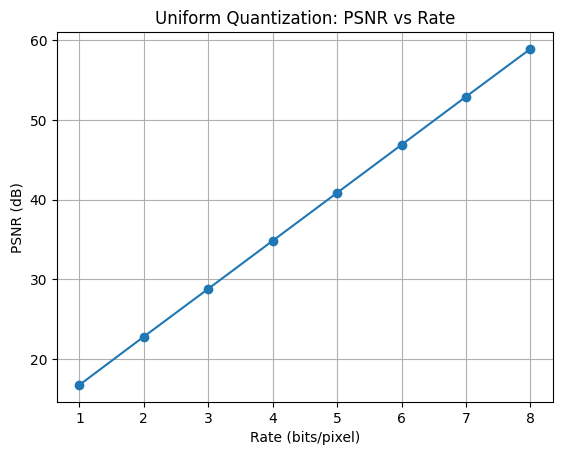

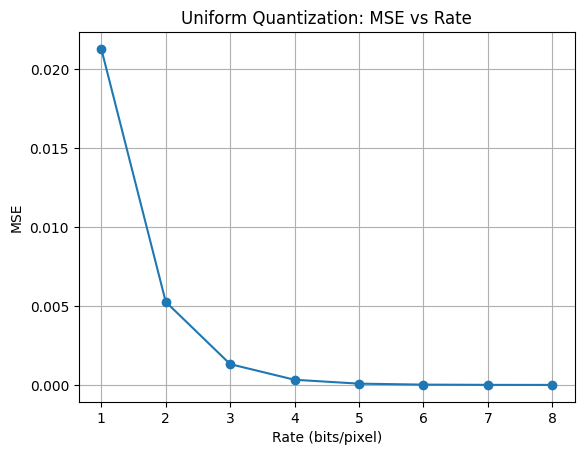

In [18]:
# PSNR vs Rate
plt.figure()
plt.plot(rates, psnrs, marker='o')
plt.xlabel('Rate (bits/pixel)')
plt.ylabel('PSNR (dB)')
plt.title('Uniform Quantization: PSNR vs Rate')
plt.grid(True)
plt.show()

# (Optional) MSE vs Rate
plt.figure()
plt.plot(rates, mses, marker='o')
plt.xlabel('Rate (bits/pixel)')
plt.ylabel('MSE')
plt.title('Uniform Quantization: MSE vs Rate')
plt.grid(True)
plt.show()

### Step 7 - (Optional) Visual comparisons at low/high bit depths
In a notebook, display original, 2‑bit, and 6‑bit reconstructions to see artifacts and banding.

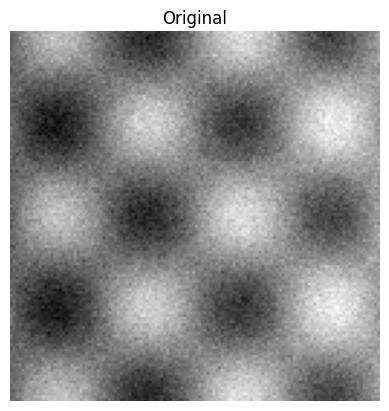

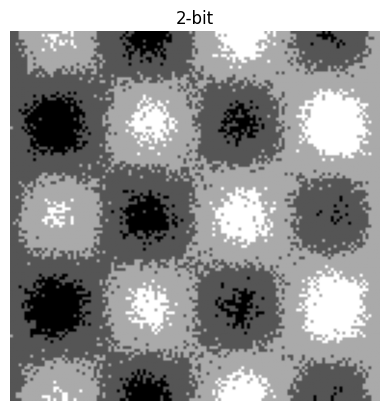

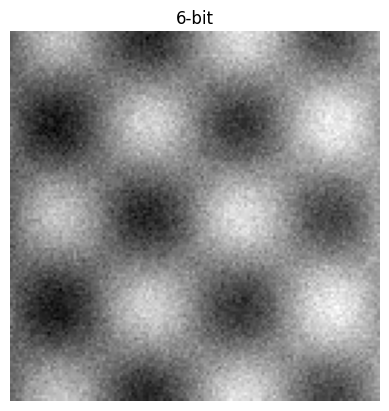

In [19]:
# Example (for a notebook):
plt.figure(); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(xhat2, cmap='gray'); plt.title('2-bit'); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(xhat6, cmap='gray'); plt.title('6-bit'); plt.axis('off'); plt.show()